In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import sqlalchemy as sqla
import csv
import matplotlib.pyplot as plt

## DATABASE CONNECTION

In [21]:
DB_USER = "postgres"
DB_PASSWORD = "a"
DB_HOST = "localhost"
DB_PORT = "5432"
DB_NAME = "postgres"

connection_string = f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"

# Créer un moteur SQLAlchemy
engine = sqla.create_engine(connection_string)

# Tester la connexion
try:
    with engine.connect() as connection:
        print("Connected to PostgreSQL successfully!")
except Exception as e:
    print(f"Error: {e}")

connection = engine.connect()

Connected to PostgreSQL successfully!


## IMPORT DATA BY HOURS DAY

In [22]:
query = """
SELECT 
w.date,
EXTRACT(HOUR FROM w.hour) AS hour_of_day,
AVG(w.temperature) AS avg_temperature,
AVG(w.dewpoint) AS avg_dewpoint,
AVG(w.relative_humidity) AS avg_relative_humidity,
AVG(w.precipitation) AS avg_precipitation,
AVG(w.snowfall) AS avg_snowfall,
AVG(w.wind_direction) AS avg_wind_direction,
AVG(w.wind_speed) AS avg_wind_speed,
AVG(w.pressure) AS avg_pressure
FROM WEATHER w
GROUP BY w.date, hour_of_day
ORDER BY w.date, hour_of_day;
"""

weather = pd.read_sql(sqla.text(query), connection)

print(weather.head())
print(weather.shape)


         date  hour_of_day  avg_temperature  avg_dewpoint  \
0  2014-01-01          0.0         5.400000      3.845455   
1  2014-01-01          1.0         5.940000      4.150000   
2  2014-01-01          2.0         5.609091      3.681818   
3  2014-01-01          3.0         5.072727      3.145455   
4  2014-01-01          4.0         5.100000      3.118182   

   avg_relative_humidity  avg_precipitation  avg_snowfall  avg_wind_direction  \
0              90.818182           0.045455           0.0          208.181818   
1              89.300000           0.080000           0.0          210.000000   
2              88.454545           0.009091           0.0          212.727273   
3              88.545455           0.000000           0.0          206.363636   
4              88.000000           0.009091           0.0          200.000000   

   avg_wind_speed  avg_pressure  
0       18.327273   1009.318187  
1       18.360000   1009.379999  
2       18.000000   1009.945451  
3       17

In [23]:
query = """
    SELECT 
        t.departure_date AS date,
        EXTRACT(HOUR FROM t.real_time_departure) AS hour_of_day,
        AVG(t.delay_arrival) AS avg_delay_arrival,
        AVG(t.delay_departure) AS avg_delay_departure
    FROM TRAIN_DATA t
    GROUP BY t.departure_date, hour_of_day
    ORDER BY t.departure_date, hour_of_day;
"""

train_data = pd.read_sql(sqla.text(query), connection)

print(train_data.head())
print(train_data.shape)

         date  hour_of_day  avg_delay_arrival  avg_delay_departure
0  2014-01-01          0.0         294.669767           342.465116
1  2014-01-01          1.0          22.523810            47.571429
2  2014-01-01          4.0          15.243902            29.804878
3  2014-01-01          5.0          21.412399            33.870620
4  2014-01-01          6.0          28.685057            41.846743
(94434, 4)


In [24]:
query = """
    SELECT * FROM TYPE_DAY;
"""

type_day = pd.read_sql(sqla.text(query), connection)

print(type_day.head())
print(type_day.shape)

         date  holiday  weekend  day_after_rest
0  2014-01-01        2    False           False
1  2014-01-02        1    False           False
2  2014-01-03        1    False           False
3  2014-01-04        1     True           False
4  2014-01-05        1     True           False
(4018, 4)


In [25]:
#Merging
merged_df = train_data.merge(weather, on=["date", "hour_of_day"], how="inner")
merged_df = type_day.merge(merged_df, on=["date"], how="inner")

#Doing this for better dealing with date
merged_df['date'] = pd.to_datetime(merged_df['date'])
merged_df['date'] = merged_df['date'].dt.dayofyear
merged_df['day_sin'] = np.sin(2 * np.pi * merged_df['date'] / 365)
merged_df['day_cos'] = np.cos(2 * np.pi * merged_df['date'] / 365)

merged_df.drop(columns=['date'], inplace=True)

print(merged_df.shape)
print(merged_df.head())

(90390, 16)
   holiday  weekend  day_after_rest  hour_of_day  avg_delay_arrival  \
0        2    False           False          0.0         294.669767   
1        2    False           False          1.0          22.523810   
2        2    False           False          4.0          15.243902   
3        2    False           False          5.0          21.412399   
4        2    False           False          6.0          28.685057   

   avg_delay_departure  avg_temperature  avg_dewpoint  avg_relative_humidity  \
0           342.465116         5.400000      3.845455              90.818182   
1            47.571429         5.940000      4.150000              89.300000   
2            29.804878         5.100000      3.118182              88.000000   
3            33.870620         4.945455      2.981818              88.181818   
4            41.846743         4.909091      2.918182              88.000000   

   avg_precipitation  avg_snowfall  avg_wind_direction  avg_wind_speed  \
0     

## Methods for regression

In [44]:
#Importing from sklearn

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor,StackingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score, KFold



## Only with the weather

In [27]:
def dummy_train(xtrain,xtest,ytrain,ytest,model):
    model.fit(xtrain,ytrain)
    ypred = model.predict(xtest)
    print("Model",model)
    print("MSE: ",mean_squared_error(ytest,ypred))
    print("MAE: ",mean_absolute_error(ytest,ypred))
    print("R2: ",r2_score(ytest,ypred))

In [28]:
x1 = merged_df[["avg_temperature", "avg_dewpoint", "avg_relative_humidity", "avg_precipitation", "avg_snowfall", "avg_wind_direction", "avg_wind_speed", "avg_pressure"]]
y1 = merged_df["avg_delay_departure"]

xtrain1, xtest1, ytrain1, ytest1 = train_test_split(x1, y1, test_size=0.2, random_state=0)

dummy_train(xtrain1,xtest1,ytrain1,ytest1,RandomForestRegressor())
dummy_train(xtrain1,xtest1,ytrain1,ytest1,LinearRegression())
dummy_train(xtrain1,xtest1,ytrain1,ytest1,Lasso())
dummy_train(xtrain1,xtest1,ytrain1,ytest1,Ridge())
dummy_train(xtrain1,xtest1,ytrain1,ytest1,SVR())
dummy_train(xtrain1,xtest1,ytrain1,ytest1,DecisionTreeRegressor())
dummy_train(xtrain1,xtest1,ytrain1,ytest1,KNeighborsRegressor())


Model RandomForestRegressor()
MSE:  382681.0308043484
MAE:  156.94476763276964
R2:  -0.14713910866038193
Model LinearRegression()
MSE:  332394.92326326674
MAE:  135.94343651637334
R2:  0.0036004261982689467
Model Lasso()
MSE:  332415.72814639326
MAE:  135.79411586578175
R2:  0.003538060694979306
Model Ridge()
MSE:  332394.914536303
MAE:  135.9432744062592
R2:  0.003600452358544892
Model SVR()
MSE:  337442.89977032185
MAE:  116.24550014979778
R2:  -0.011531578799915287
Model DecisionTreeRegressor()
MSE:  902031.4938060209
MAE:  203.61128707319602
R2:  -1.703963668158055
Model KNeighborsRegressor()
MSE:  408721.0757082137
MAE:  162.83509923810865
R2:  -0.2251977305829529


## Only the date information

In [29]:
x2 = merged_df[["day_sin","day_cos","holiday","weekend", "day_after_rest", "hour_of_day"]]
y2 = merged_df["avg_delay_departure"]

xtrain2, xtest2, ytrain2, ytest2 = train_test_split(x2, y2, test_size=0.2, random_state=0)

dummy_train(xtrain2,xtest2,ytrain2,ytest2,RandomForestRegressor())
dummy_train(xtrain2,xtest2,ytrain2,ytest2,LinearRegression())
dummy_train(xtrain2,xtest2,ytrain2,ytest2,Lasso())
dummy_train(xtrain2,xtest2,ytrain2,ytest2,Ridge())
dummy_train(xtrain2,xtest2,ytrain2,ytest2,SVR())
dummy_train(xtrain2,xtest2,ytrain2,ytest2,DecisionTreeRegressor())
dummy_train(xtrain2,xtest2,ytrain2,ytest2,KNeighborsRegressor())


Model RandomForestRegressor()
MSE:  402817.2325837899
MAE:  125.20433323977637
R2:  -0.20750014749348744
Model LinearRegression()
MSE:  329472.46378288674
MAE:  141.28467507488637
R2:  0.012360901093961374
Model Lasso()
MSE:  329496.2032279227
MAE:  141.09249791077295
R2:  0.012289738837077624
Model Ridge()
MSE:  329472.4643139953
MAE:  141.28458829910542
R2:  0.012360899501890232
Model SVR()
MSE:  336333.8095218235
MAE:  111.53264475830235
R2:  -0.008206927989782065
Model DecisionTreeRegressor()
MSE:  538322.1747167003
MAE:  137.75947283712557
R2:  -0.6136948789404615
Model KNeighborsRegressor()
MSE:  352989.65491310507
MAE:  117.94979512451233
R2:  -0.0581351190892474


In [30]:

x3 = merged_df[["day_sin","day_cos","holiday","weekend", "day_after_rest", "hour_of_day", "avg_temperature", "avg_dewpoint", "avg_relative_humidity", "avg_precipitation", "avg_snowfall", "avg_wind_direction", "avg_wind_speed", "avg_pressure"]]
y3 = merged_df["avg_delay_departure"]

xtrain3, xtest3, ytrain3, ytest3 = train_test_split(x3, y3, test_size=0.2, random_state=0)

dummy_train(xtrain3,xtest3,ytrain3,ytest3,RandomForestRegressor())
dummy_train(xtrain3,xtest3,ytrain3,ytest3,LinearRegression())
dummy_train(xtrain3,xtest3,ytrain3,ytest3,Lasso())
dummy_train(xtrain3,xtest3,ytrain3,ytest3,Ridge())
dummy_train(xtrain3,xtest3,ytrain3,ytest3,SVR())
dummy_train(xtrain3,xtest3,ytrain3,ytest3,DecisionTreeRegressor())
dummy_train(xtrain3,xtest3,ytrain3,ytest3,KNeighborsRegressor())


Model RandomForestRegressor()
MSE:  319419.9227922856
MAE:  103.12300395896547
R2:  0.0424947775693435
Model LinearRegression()
MSE:  328989.8988890808
MAE:  140.6499184373314
R2:  0.013807455842149041
Model Lasso()
MSE:  329063.92919064214
MAE:  140.53435528828004
R2:  0.01358553981467192
Model Ridge()
MSE:  328989.92612537585
MAE:  140.64974305875324
R2:  0.013807374197602362
Model SVR()
MSE:  337525.76818993164
MAE:  116.19066188049509
R2:  -0.011779988303797673
Model DecisionTreeRegressor()
MSE:  528875.7736507818
MAE:  133.78050144073603
R2:  -0.5853779903922374
Model KNeighborsRegressor()
MSE:  392982.8971343241
MAE:  151.01737881866555
R2:  -0.1780203721880449


## Trying just  by day.

In [31]:
query = """
    SELECT 
        t.departure_date AS date,
        AVG(t.delay_arrival) AS avg_delay_arrival,
        AVG(t.delay_departure) AS avg_delay_departure
    FROM TRAIN_DATA t
    GROUP BY t.departure_date
    ORDER BY t.departure_date;
"""

train_data = pd.read_sql(sqla.text(query), connection)

query = """
SELECT 
w.date,
AVG(w.temperature) AS avg_temperature,
AVG(w.dewpoint) AS avg_dewpoint,
AVG(w.relative_humidity) AS avg_relative_humidity,
AVG(w.precipitation) AS avg_precipitation,
AVG(w.snowfall) AS avg_snowfall,
AVG(w.wind_direction) AS avg_wind_direction,
AVG(w.wind_speed) AS avg_wind_speed,
AVG(w.pressure) AS avg_pressure
FROM WEATHER w
GROUP BY w.date
ORDER BY w.date;
"""

weather = pd.read_sql(sqla.text(query), connection)


merged_df = train_data.merge(weather, on=["date"], how="inner")
merged_df = type_day.merge(merged_df, on=["date"], how="inner")

merged_df['date'] = pd.to_datetime(merged_df['date'])
#merged_df = merged_df[merged_df['date'] < '2020-01-01']
merged_df['date'] = merged_df['date'].dt.dayofyear
merged_df['day_sin'] = np.sin(2 * np.pi * merged_df['date'] / 365)
merged_df['day_cos'] = np.cos(2 * np.pi * merged_df['date'] / 365)

merged_df.drop(columns=['date'], inplace=True)
print(merged_df.shape)
print(merged_df.head())

(4018, 15)
   holiday  weekend  day_after_rest  avg_delay_arrival  avg_delay_departure  \
0        2    False           False          38.000104            47.338924   
1        1    False           False          61.479792            69.302843   
2        1    False           False         131.355574           137.877869   
3        1     True           False          73.400835            81.274319   
4        1     True           False          63.745558            71.634720   

   avg_temperature  avg_dewpoint  avg_relative_humidity  avg_precipitation  \
0         6.834615      4.222308              84.692308           0.005769   
1         8.257252      5.640076              84.694656           0.029008   
2         8.838931      5.646947              81.770992           0.017557   
3         7.535938      4.859375              84.109375           0.000000   
4         4.975379      2.743182              86.128788           0.014015   

   avg_snowfall  avg_wind_direction  avg_wind

In [32]:

x4 = merged_df[["avg_temperature", "avg_dewpoint", "avg_relative_humidity", "avg_precipitation", "avg_snowfall", "avg_wind_direction", "avg_wind_speed", "avg_pressure"]]
y4 = merged_df["avg_delay_departure"]

xtrain4, xtest4, ytrain4, ytest4 = train_test_split(x4, y4, test_size=0.2, random_state=0)

dummy_train(xtrain4,xtest4,ytrain4,ytest4,RandomForestRegressor())
dummy_train(xtrain4,xtest4,ytrain4,ytest4,LinearRegression())
dummy_train(xtrain4,xtest4,ytrain4,ytest4,Lasso())
dummy_train(xtrain4,xtest4,ytrain4,ytest4,Ridge())
dummy_train(xtrain4,xtest4,ytrain4,ytest4,SVR())
dummy_train(xtrain4,xtest4,ytrain4,ytest4,DecisionTreeRegressor())
dummy_train(xtrain4,xtest4,ytrain4,ytest4,KNeighborsRegressor())


Model RandomForestRegressor()
MSE:  3144.4608779628325
MAE:  40.63768798459948
R2:  -0.12743844223537848
Model LinearRegression()
MSE:  2712.138435922883
MAE:  37.90551302313932
R2:  0.02756966869799482
Model Lasso()
MSE:  2743.036743171304
MAE:  37.95245062912098
R2:  0.016491159298813396
Model Ridge()
MSE:  2711.966695918406
MAE:  37.91600073853667
R2:  0.027631245639363144
Model SVR()
MSE:  2881.1180776471915
MAE:  37.96024857376895
R2:  -0.03301755163294251
Model DecisionTreeRegressor()
MSE:  5382.33716827943
MAE:  54.58529426143451
R2:  -0.9298232886655955
Model KNeighborsRegressor()
MSE:  3775.7458065534333
MAE:  43.10099737920248
R2:  -0.3537840461781323


In [33]:
x5 = merged_df[["day_sin","day_cos","holiday","weekend", "day_after_rest"]]
y5 = merged_df["avg_delay_departure"]

xtrain5, xtest5, ytrain5, ytest5 = train_test_split(x5, y5, test_size=0.2, random_state=0)

dummy_train(xtrain5,xtest5,ytrain5,ytest5,RandomForestRegressor())
dummy_train(xtrain5,xtest5,ytrain5,ytest5,LinearRegression())
dummy_train(xtrain5,xtest5,ytrain5,ytest5,Lasso())
dummy_train(xtrain5,xtest5,ytrain5,ytest5,Ridge())
dummy_train(xtrain5,xtest5,ytrain5,ytest5,SVR())
dummy_train(xtrain5,xtest5,ytrain5,ytest5,DecisionTreeRegressor())
dummy_train(xtrain5,xtest5,ytrain5,ytest5,KNeighborsRegressor())



Model RandomForestRegressor()
MSE:  3236.3836057173758
MAE:  39.15610111223381
R2:  -0.16039710224349757
Model LinearRegression()
MSE:  2433.088059437893
MAE:  34.90946300853379
R2:  0.1276224707456569
Model Lasso()
MSE:  2424.177301785332
MAE:  34.7840165456721
R2:  0.13081740021587163
Model Ridge()
MSE:  2432.9555839398067
MAE:  34.908055294974176
R2:  0.1276699694982233
Model SVR()
MSE:  2368.590825407921
MAE:  33.18103753979106
R2:  0.15074778980205195
Model DecisionTreeRegressor()
MSE:  3544.649611721069
MAE:  41.74106544237758
R2:  -0.2709250938743204
Model KNeighborsRegressor()
MSE:  3123.3291696071524
MAE:  37.61806072974822
R2:  -0.11986172200417133


In [34]:
x6 = merged_df[["day_sin","day_cos","holiday","weekend", "day_after_rest", "avg_temperature", "avg_dewpoint", "avg_relative_humidity", "avg_precipitation", "avg_snowfall", "avg_wind_direction", "avg_wind_speed", "avg_pressure"]]
y6 = merged_df["avg_delay_departure"]

xtrain6, xtest6, ytrain6, ytest6 = train_test_split(x6, y6, test_size=0.2, random_state=0)

dummy_train(xtrain6,xtest6,ytrain6,ytest6,RandomForestRegressor(random_state=0))
dummy_train(xtrain6,xtest6,ytrain6,ytest6,LinearRegression())
dummy_train(xtrain6,xtest6,ytrain6,ytest6,Lasso())
dummy_train(xtrain6,xtest6,ytrain6,ytest6,Ridge())
dummy_train(xtrain6,xtest6,ytrain6,ytest6,SVR())
dummy_train(xtrain6,xtest6,ytrain6,ytest6,DecisionTreeRegressor())
dummy_train(xtrain6,xtest6,ytrain6,ytest6,KNeighborsRegressor())


Model RandomForestRegressor(random_state=0)
MSE:  1977.40916636737
MAE:  31.313504695096984
R2:  0.29100497773229483
Model LinearRegression()
MSE:  2391.3205754617065
MAE:  34.89709651333438
R2:  0.14259809578848182
Model Lasso()
MSE:  2418.59265900674
MAE:  34.89082863168888
R2:  0.13281975966605997
Model Ridge()
MSE:  2391.1445491984764
MAE:  34.902996200922374
R2:  0.14266120955701345
Model SVR()
MSE:  2880.966020021802
MAE:  37.964824306313325
R2:  -0.03296303175848614
Model DecisionTreeRegressor()
MSE:  4861.972457496973
MAE:  47.06505492319485
R2:  -0.7432478464235148
Model KNeighborsRegressor()
MSE:  3712.1462254687776
MAE:  42.762659813355704
R2:  -0.3309805782999242


In [35]:
query = """
    SELECT 
        t.departure_date AS date,
        AVG(t.delay_arrival) AS avg_delay_arrival,
        AVG(t.delay_departure) AS avg_delay_departure
    FROM TRAIN_DATA t
    GROUP BY t.departure_date
    ORDER BY t.departure_date;
"""

train_data = pd.read_sql(sqla.text(query), connection)

query = """
SELECT 
w.date,
AVG(w.temperature) AS avg_temperature,
AVG(w.dewpoint) AS avg_dewpoint,
AVG(w.relative_humidity) AS avg_relative_humidity,
AVG(w.precipitation) AS avg_precipitation,
AVG(w.snowfall) AS avg_snowfall,
AVG(w.wind_direction) AS avg_wind_direction,
AVG(w.wind_speed) AS avg_wind_speed,
AVG(w.pressure) AS avg_pressure
FROM WEATHER w
GROUP BY w.date
ORDER BY w.date;
"""

weather = pd.read_sql(sqla.text(query), connection)


merged_df = train_data.merge(weather, on=["date"], how="inner")
merged_df = type_day.merge(merged_df, on=["date"], how="inner")

merged_df['date'] = pd.to_datetime(merged_df['date'])
merged_df = merged_df[merged_df['date'] < '2020-01-01']
merged_df['date'] = merged_df['date'].dt.dayofyear
merged_df['day_sin'] = np.sin(2 * np.pi * merged_df['date'] / 365)
merged_df['day_cos'] = np.cos(2 * np.pi * merged_df['date'] / 365)

merged_df.drop(columns=['date'], inplace=True)
print(merged_df.shape)
print(merged_df.head())

(2191, 15)
   holiday  weekend  day_after_rest  avg_delay_arrival  avg_delay_departure  \
0        2    False           False          38.000104            47.338924   
1        1    False           False          61.479792            69.302843   
2        1    False           False         131.355574           137.877869   
3        1     True           False          73.400835            81.274319   
4        1     True           False          63.745558            71.634720   

   avg_temperature  avg_dewpoint  avg_relative_humidity  avg_precipitation  \
0         6.834615      4.222308              84.692308           0.005769   
1         8.257252      5.640076              84.694656           0.029008   
2         8.838931      5.646947              81.770992           0.017557   
3         7.535938      4.859375              84.109375           0.000000   
4         4.975379      2.743182              86.128788           0.014015   

   avg_snowfall  avg_wind_direction  avg_wind

In [41]:
x7 = merged_df[["day_sin","day_cos","holiday","weekend", "day_after_rest", "avg_temperature", "avg_dewpoint", "avg_relative_humidity", "avg_precipitation", "avg_snowfall", "avg_wind_direction", "avg_wind_speed", "avg_pressure"]]
y7 = merged_df["avg_delay_departure"]

xtrain7, xtest7, ytrain7, ytest7 = train_test_split(x7, y7, test_size=0.2, random_state=0)

dummy_train(xtrain7,xtest7,ytrain7,ytest7,RandomForestRegressor(random_state=10))
dummy_train(xtrain7,xtest7,ytrain7,ytest7,LinearRegression())
dummy_train(xtrain7,xtest7,ytrain7,ytest7,Lasso(max_iter=10000))
dummy_train(xtrain7,xtest7,ytrain7,ytest7,Ridge())
dummy_train(xtrain7,xtest7,ytrain7,ytest7,SVR())
dummy_train(xtrain7,xtest7,ytrain7,ytest7,DecisionTreeRegressor())
dummy_train(xtrain7,xtest7,ytrain7,ytest7,KNeighborsRegressor())


Model RandomForestRegressor(random_state=10)
MSE:  2635.8925142733046
MAE:  33.9234198053881
R2:  0.17260199910000285
Model LinearRegression()
MSE:  2535.1886525442037
MAE:  34.425187778056504
R2:  0.20421261046840278
Model Lasso(max_iter=10000)
MSE:  2644.9895813859976
MAE:  35.284755431540354
R2:  0.16974645961865564
Model Ridge()
MSE:  2543.680105006
MAE:  34.503591384703135
R2:  0.20154717143643053
Model SVR()
MSE:  3300.6595510702427
MAE:  39.34413764507969
R2:  -0.0360661898840382
Model DecisionTreeRegressor()
MSE:  4699.670358742745
MAE:  43.992085487750344
R2:  -0.4752110864371675
Model KNeighborsRegressor()
MSE:  4302.509299701202
MAE:  43.84157294983296
R2:  -0.35054353474191413


In [ ]:
#Hyperparameter tuning for Lasso and Ridge

def HyperparameterTuning(model, xtrain, ytrain, alphas, max_iter=20000):
    train_scores = []
    test_scores = []
    kf = KFold(n_splits=10, shuffle=True, random_state=0)
    for alpha in alphas:
        train_folds = []
        test_folds = []
        for train_idx, test_idx in kf.split(xtrain):
            X_train, X_test = xtrain.iloc[train_idx], xtrain.iloc[test_idx]
            y_train, y_test = ytrain.iloc[train_idx], ytrain.iloc[test_idx]
            model.set_params(alpha=alpha, max_iter=max_iter)
            model.fit(X_train, y_train)
            y_pred_train = model.predict(X_train)
            y_pred_test = model.predict(X_test)
            train_folds.append(r2_score(y_train, y_pred_train))
            test_folds.append(r2_score(y_test, y_pred_test))
        train_scores.append(np.mean(train_folds))
        test_scores.append(np.mean(test_folds))
    return train_scores, test_scores

alphas = np.linspace(1e-10, 10, 50)


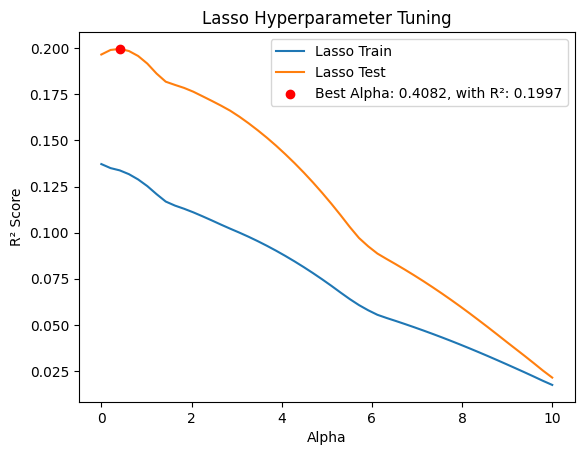

In [76]:
train, test = HyperparameterTuning(Lasso(), xtrain7, ytrain7, xtest7, ytest7, alphas)
plt.plot(alphas, train, label="Lasso Train")
plt.plot(alphas, test, label="Lasso Test")
best_index = np.argmax(test)
best_alpha_value = alphas[best_index]
best_score = test[best_index]
plt.scatter(best_alpha_value, best_score, color='red', zorder=3, label=f"Best Alpha: {best_alpha_value:.4f}, with R²: {best_score:.4f}")
plt.xlabel("Alpha")
plt.ylabel("R² Score")
plt.title("Lasso Hyperparameter Tuning")
plt.legend()
plt.show()


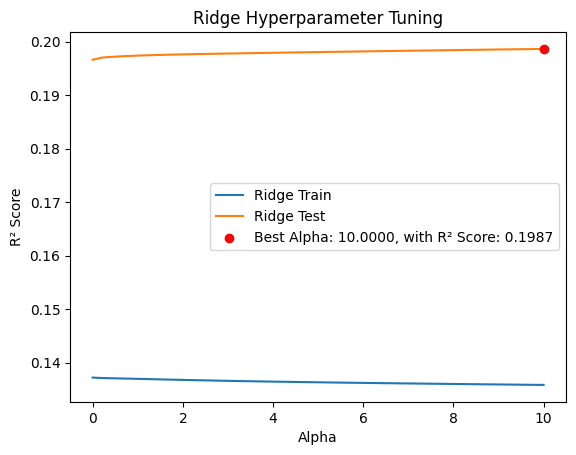

In [75]:
train, test = HyperparameterTuning(Ridge(), xtrain7, ytrain7, xtest7, ytest7, alphas)
plt.plot(alphas, train, label="Ridge Train")
plt.plot(alphas, test, label="Ridge Test")
best_index = np.argmax(test)
best_alpha_value = alphas[best_index]
best_score = test[best_index]
plt.scatter(best_alpha_value, best_score, color='red', zorder=3, label=f"Best Alpha: {best_alpha_value:.4f}, with R² Score: {best_score:.4f}")
plt.xlabel("Alpha")
plt.ylabel("R² Score")
plt.title("Ridge Hyperparameter Tuning")
plt.legend()
plt.show()


In [87]:
# Hyperparameter tuning for RandomForestRegressor

def HyperparameterTuningRandomForestRegressor(xtrain, ytrain, xtest, ytest, n_estimators, max_depths):

    train_scores = []
    test_scores = []
    kf = KFold(n_splits=10, shuffle=True, random_state=0)
    for n_estimator in n_estimators:
        for max_depth in max_depths:
            train_folds = []
            test_folds = []
            for train_idx, test_idx in kf.split(xtrain):
                X_train, X_test = xtrain.iloc[train_idx], xtrain.iloc[test_idx]
                y_train, y_test = ytrain.iloc[train_idx], ytrain.iloc[test_idx]
                model = RandomForestRegressor(n_estimators=n_estimator, max_depth=max_depth, random_state=0)
                model.fit(X_train, y_train)
                y_pred_train = model.predict(X_train)
                y_pred_test = model.predict(X_test)
                train_folds.append(r2_score(y_train, y_pred_train))
                test_folds.append(r2_score(y_test, y_pred_test))
            train_scores.append(np.mean(train_folds))
            test_scores.append(np.mean(test_folds))
    return train_scores, test_scores

n_estimators = [10, 25, 50, 75, 100, 150]
max_depths = [2, 5, 10, 20,50,100, None]

train, test = HyperparameterTuningRandomForestRegressor(xtrain7, ytrain7, xtest7, ytest7, n_estimators, max_depths)





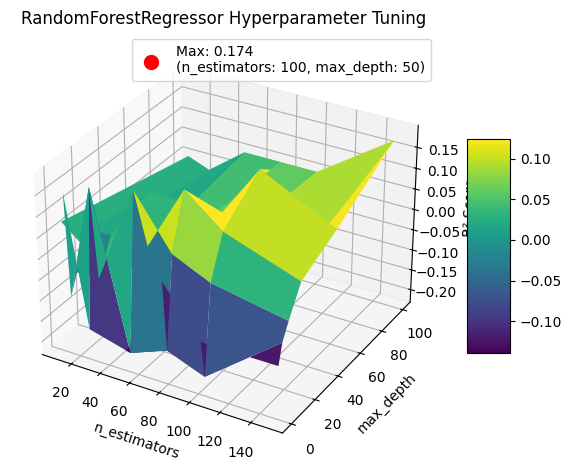

In [88]:
plot_max_depths = [md if md is not None else 0 for md in max_depths]
X, Y = np.meshgrid(n_estimators, plot_max_depths)
Z = np.array(test).reshape(len(max_depths), len(n_estimators))

max_index = np.unravel_index(np.argmax(Z), Z.shape)
best_max_depth = plot_max_depths[max_index[0]]
best_n_estimator = n_estimators[max_index[1]]
best_score = Z[max_index]

# Create a 3D surface plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')  
surf = ax.plot_surface(X, Y, Z, cmap='viridis')
ax.scatter(best_n_estimator, best_max_depth, best_score, color='red', s=100, 
           label=f"Max: {best_score:.3f}\n(n_estimators: {best_n_estimator}, max_depth: {best_max_depth})")

ax.set_xlabel('n_estimators')
ax.set_ylabel('max_depth')
ax.set_zlabel('R² Score')
ax.set_title("RandomForestRegressor Hyperparameter Tuning")
plt.colorbar(surf, ax=ax, shrink=0.5, aspect=5)  
plt.legend()
plt.tight_layout()
plt.show()

## Let's see some particular values.

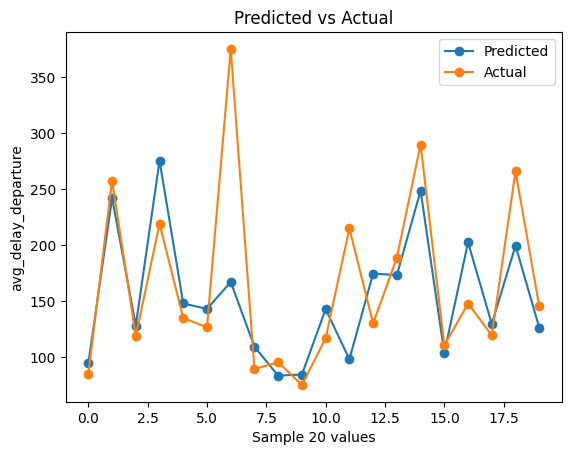

day_sin                    -0.989932
day_cos                      0.14154
holiday                            0
weekend                        False
day_after_rest                 False
avg_temperature            10.178723
avg_dewpoint                7.912766
avg_relative_humidity      86.765957
avg_precipitation           0.001277
avg_snowfall                     0.0
avg_wind_direction        144.808511
avg_wind_speed              4.963404
avg_pressure             1022.334469
Name: 646, dtype: object


In [100]:

rf = RandomForestRegressor(n_estimators=best_n_estimator, max_depth=best_max_depth, random_state=0)
rf.fit(xtrain7, ytrain7)

new_x = xtest7.iloc[0:20]  
new_y = ytest7.iloc[0:20]

predictions = rf.predict(new_x)
comparison_df = pd.DataFrame({'Predicted': predictions,'Actual': new_y.values}, index=new_y.index)

plt.plot(predictions, label='Predicted', marker='o')
plt.plot(new_y.values, label='Actual', marker='o')
plt.title("Predicted vs Actual")
plt.xlabel("Sample 20 values")
plt.ylabel("avg_delay_departure")
plt.legend()
plt.show()

print(new_x.iloc[6])

By doing the reverse of day_sin and day_cos, we are going to have 9 October.